### Решение соревнования https://zindi.africa/competitions/classification-for-landslide-detection демонстрирует процесс создания и обучения модели глубокого обучения для бинарной классификации оползней на основе мультиспектральных данных и Sentinel-2.
### Метрика соревнования - f1
### После импорта из kaggle notebook некоторые выводы после запуска кода пропали

### Выполняем установку библиотеки comet_ml. Comet ML – это платформа для отслеживания, сравнения и оптимизации экспериментов машинного обучения

In [1]:
# Import necessary libraries
!pip install comet_ml > /dev/null 2>&1

### Импорт необходимых библиотек

In [2]:
import comet_ml
COMET_API_KEY = "48wT0zIAmJHLfyXk2ucSQALNv"
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from scipy.ndimage import rotate, shift, zoom
data = "/kaggle/input/slideandseekclasificationlandslidedetectiondataset"

2025-07-15 08:26:55.321755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752568015.343970     211 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752568015.351346     211 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Определение путей к данным и предварительная загрузка CSV-файлов train и test

In [3]:
train_csv_path = f'{data}/Train.csv'
test_csv_path = f'{data}/Test.csv'
train_data_path = f'{data}/train_data/train_data'
test_data_path = f'{data}/test_data/test_data'

train_df = pd.read_csv(train_csv_path)
print("Train.csv:")
print(train_df.head())

Train.csv:
          ID  label
0  ID_HUD1ST      1
1  ID_KGE2HY      1
2  ID_VHV9BL      1
3  ID_ZT0VEJ      0
4  ID_5NFXVY      0


### Визуализация распределения классов (Нет последствий оползня/ после оползня)

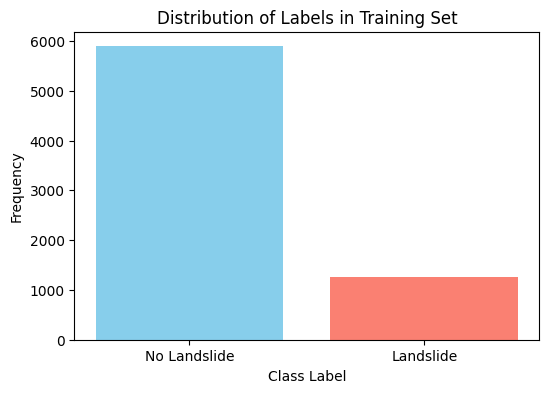

In [5]:
label_counts = train_df['label'].value_counts()
labels = ['No Landslide', 'Landslide']

plt.figure(figsize=(6, 4))
plt.bar(labels, label_counts.values, color=['skyblue', 'salmon'])
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Distribution of Labels in Training Set")
plt.show()

### Как видно из графика есть сильный дисбаланс классов No Landslide ~ 6000 изображений, Landslide ~ 1400 изображений
### Далее эта проблема будет решена с помощью Focal loss

### Функция загрузки и нормализации изображений, а также их визуализация
###  Изображения состоят из 12 каналов (4 оптических из Sentinel-2 и 8 SAR из Sentinel-1) и размером 64x64. Для каждого канала выполняется надежная нормализация по процентилям (2-й и 98-й), чтобы сделать значения пикселей в диапазоне [0, 1] и уменьшить влияние выбросов, которые могут быть в спутниковых данных. Также были протестированы нормализация по 1/99 процентилям и minmax шкалирование(закоментированный код), но они дали результаты похуже.

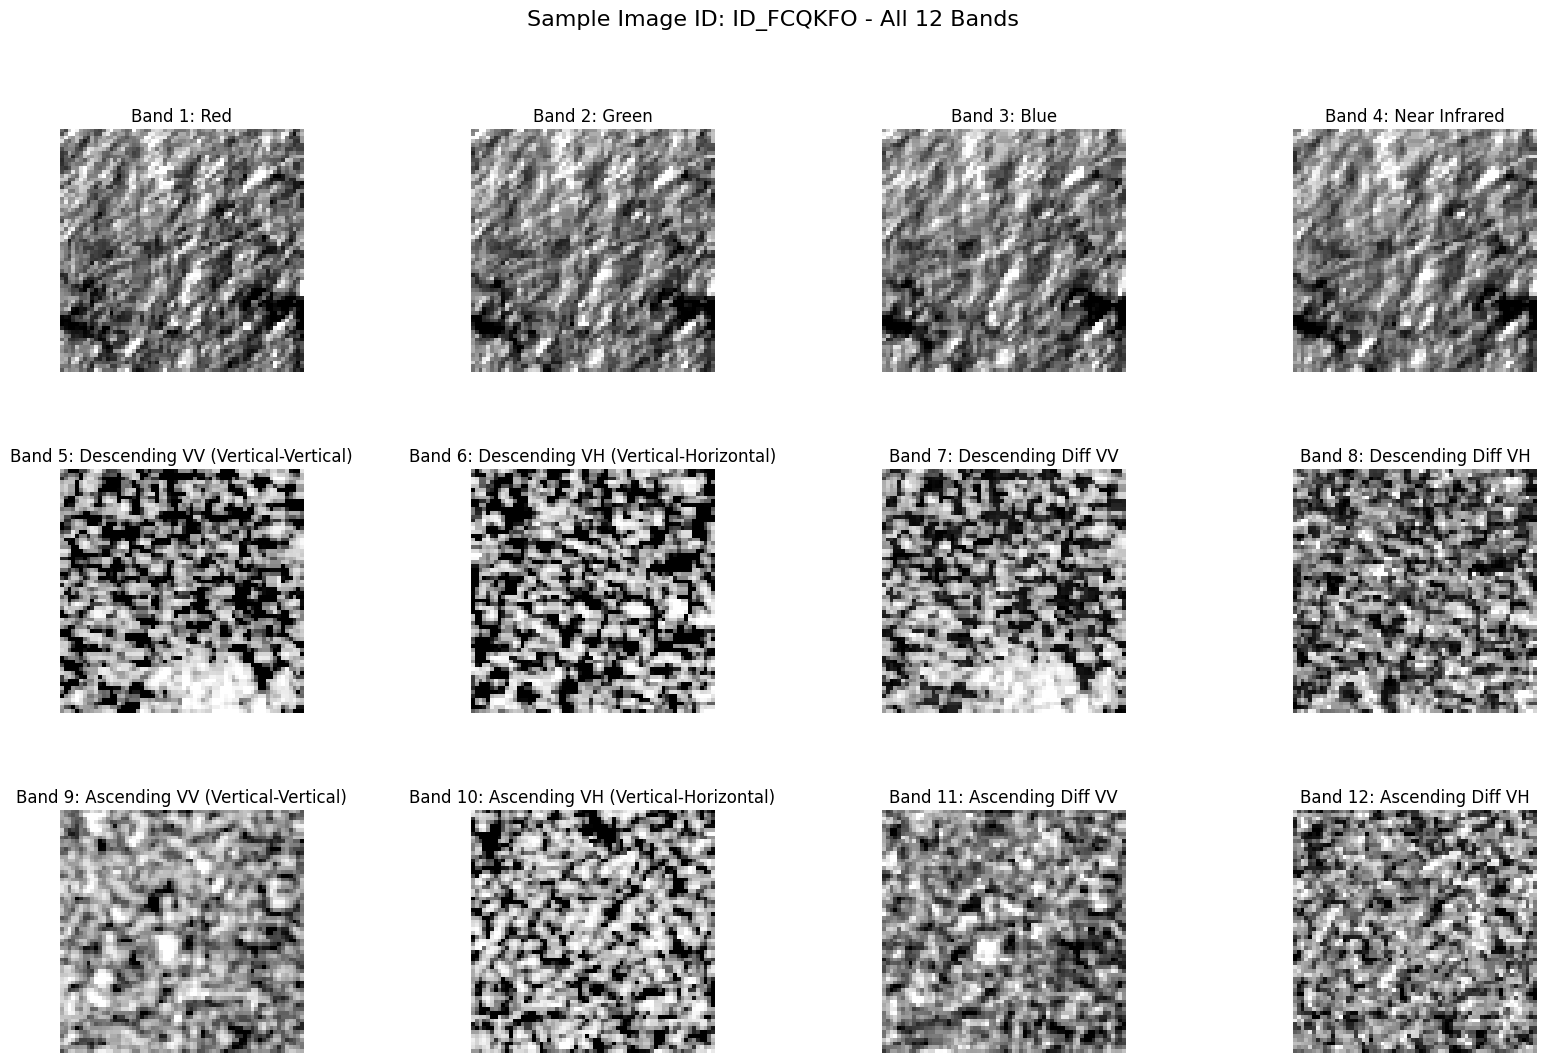

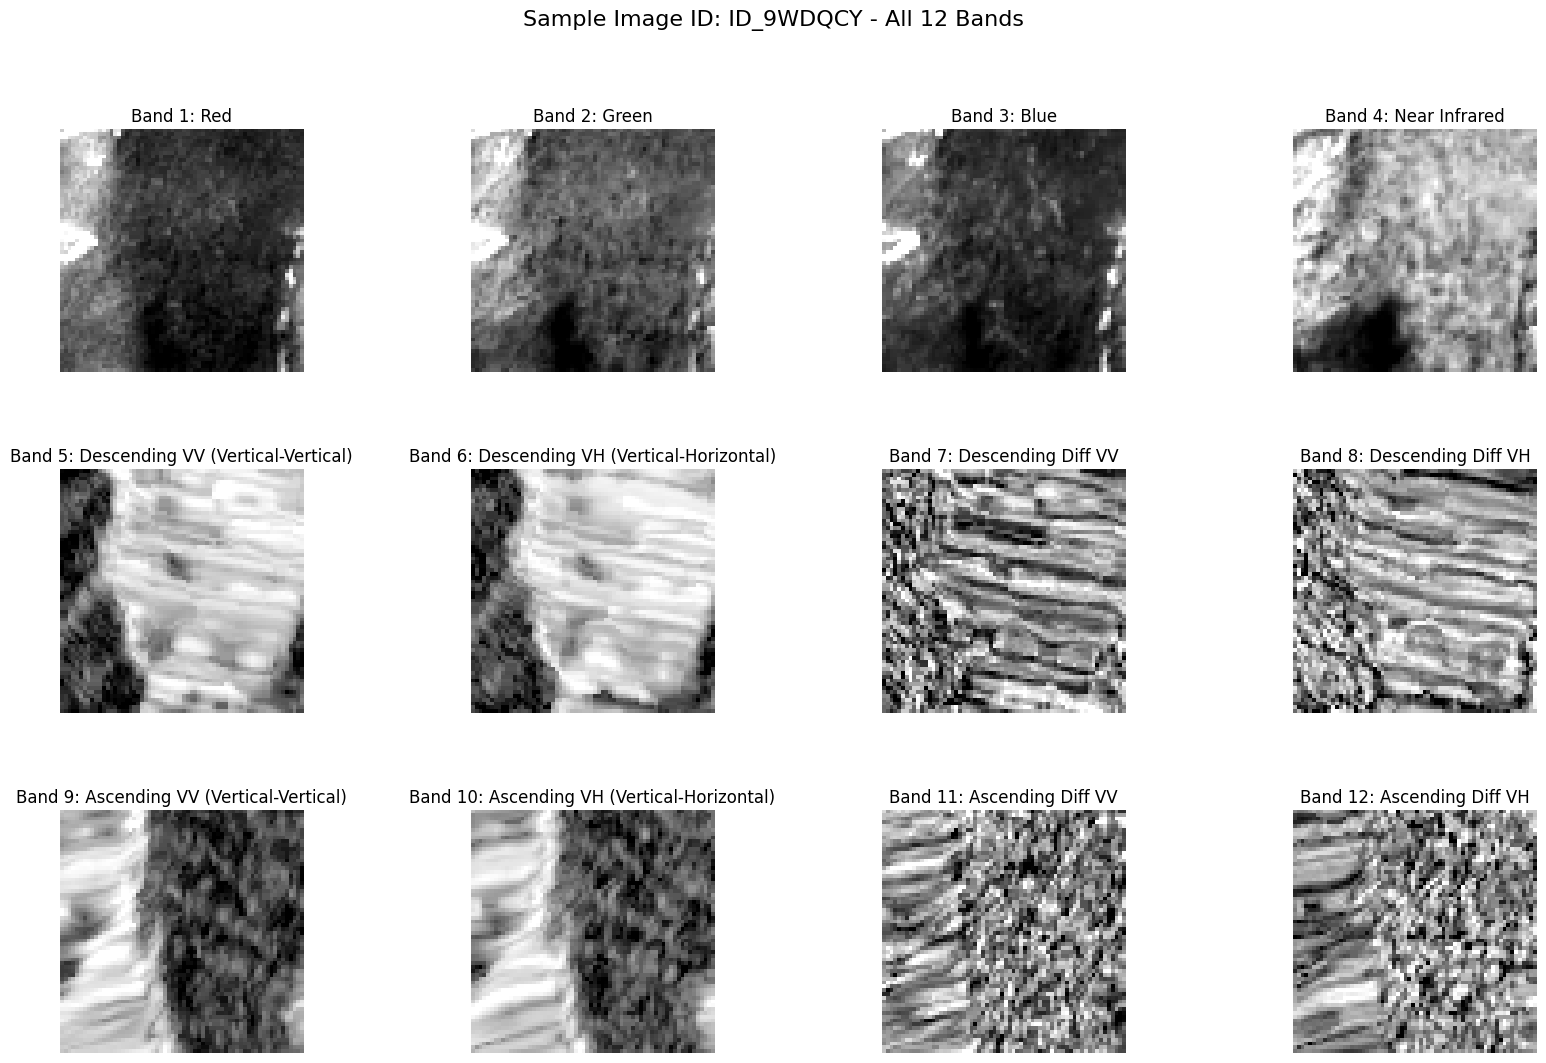

In [6]:
def load_and_normalize_npy_image(image_id, folder_path):
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    img = np.load(image_path).astype(np.float32)

    normalized_img = img
    for band in range(img.shape[2]):
        band_data = img[:, :, band]
        
        p2, p98 = np.percentile(band_data, (2, 98))
        normalized_img[:, :, band] = np.clip((band_data - p2) / (p98 - p2 + 1e-6), 0, 1)
        
    #     p1, p99 = np.percentile(band_data, (1, 99))

    #     clipped_data = np.clip(band_data, p1, p99)
    #     mean_val = np.mean(clipped_data)
    #     std_val = np.std(clipped_data)
        
    #     if std_val > 0:
    #         normalized_img[:, :, band] = (clipped_data - mean_val) / std_val
    #     else:
    #         normalized_img[:, :, band] = clipped_data - mean_val
    
    # for band in range(img.shape[2]):
    #     band_data = normalized_img[:, :, band]
    #     min_val, max_val = np.min(band_data), np.max(band_data)
    #     if max_val > min_val:
    #         normalized_img[:, :, band] = (band_data - min_val) / (max_val - min_val)
    
    return normalized_img

band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV (Vertical-Vertical)", "Descending VH (Vertical-Horizontal)",
    "Descending Diff VV", "Descending Diff VH",
    "Ascending VV (Vertical-Vertical)", "Ascending VH (Vertical-Horizontal)",
    "Ascending Diff VV", "Ascending Diff VH"
]

example_ids = train_df['ID'].sample(2,random_state = 42).values

for image_id in example_ids:
    img_normalized = load_and_normalize_npy_image(image_id, train_data_path)

    fig, axes = plt.subplots(3, 4, figsize=(20, 12))
    fig.suptitle(f"Sample Image ID: {image_id} - All 12 Bands", fontsize=16)

    for band in range(12):
        row = band // 4
        col = band % 4
        axes[row, col].imshow(img_normalized[:, :, band], cmap='gray')
        axes[row, col].set_title(f"Band {band + 1}: {band_descriptions[band]}")
        axes[row, col].axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.show()

### Вот так выглядят два 12 канальных изображения (первые три канала привычные RGB, дальше инфракрсаное и другие виды производимых и принимаемых Sentinel 2 излучений.

### Определение генератора данных для загрузки данных батчами с рандомными примерами из train и применение слуяайных аугментаций ( поворот 15 градусов, сдвиги по ширине и высоте, масштабирование, отражения и заполнение появившихся пропусков у краев.)

In [8]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

class LandslideDataGenerator(Sequence):
    def __init__(self, df, data_path, batch_size=32, augment=False, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.data_path = data_path
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

        if self.augment:
            self.augmentor = ImageDataGenerator(
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,
                fill_mode='reflect' 
            )
        else:
            self.augmentor = None

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
        
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]
        
        batch_X = []
        batch_y = []
        
        for _, row in batch_df.iterrows():
            image_id = row['ID']
            label = row['label']
           
            image = load_and_normalize_npy_image(image_id, self.data_path)
            batch_X.append(image)
            batch_y.append(label)
        
        batch_X = np.array(batch_X, dtype=np.float32)
        batch_y = np.array(batch_y, dtype=np.float32).reshape(-1, 1)

        if self.augment and self.augmentor:
            batch_X = next(self.augmentor.flow(batch_X, batch_size=len(batch_X), shuffle=False))
        return batch_X, batch_y


### Проверка работы LandslideDataGenerator

In [9]:
folder_path = '/kaggle/input/slideandseekclasificationlandslidedetectiondataset/train_data/train_data/'

batch_size = 16

train_df_split, val_df_split = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

train_gen = LandslideDataGenerator(train_df_split, folder_path, batch_size=batch_size, augment=True, shuffle=True)
val_gen = LandslideDataGenerator(val_df_split, folder_path, batch_size=batch_size, augment=False, shuffle=False)

X_batch, y_batch = train_gen[0]

X_batch.shape, y_batch.shape

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (16, 64, 64, 12) (12 channels).
  warnings.warn(


((16, 64, 64, 12), (16, 1))

### Как видим в X батче 16 изображений 64x64 по 12 каналов и в label(y) батче 16 соответствующих изображениям классов

### Вывод y_batch

In [10]:
y_batch

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

### Определение функции потерь Focal Loss
### Focal Loss был разработан для решения проблемы дисбаланса классов в задачах, где один класс значительно преобладает над другим (как в случае с оползнями). Он модифицирует стандартную кросс-энтропийную потерю, уменьшая вес "легких" (хорошо классифицируемых) примеров и увеличивая вес "сложных" (плохо классифицируемых) примеров, особенно для миноритарного класса.

### gamma (параметр фокусировки): контролирует, насколько сильно подавляются "легкие" примеры. Большее gamma -> сильнее фокусировка на сложных.

### alpha (балансирующий фактор):Для редкого положительного класса alpha обычно устанавливается высоким (например, 0.75 или 0.9 в зависимости от степени дисбаланса). В текущей реализации alpha=None по умолчанию, что означает автоматический расчет весов(по количеству примеров классов в train).

In [12]:
def focal_loss(gamma=2.0, alpha=0.75):
    """
    Focal Loss for binary classification.

    Parameters:
        gamma (float): Focusing parameter; typically set to 2.0.
        alpha (float): Balancing factor; typically set to 0.25.

    Returns:
        Binary Focal Loss function.
    """
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        if alpha is None:

            pos_weight = K.mean(1 - y_true)
            neg_weight = K.mean(y_true)
            alpha_t = tf.where(K.equal(y_true, 1), pos_weight, neg_weight)
        else:
            alpha_t = tf.where(K.equal(y_true, 1), alpha, 1 - alpha)

        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)

        fl = -alpha_t * K.pow(1 - p_t, gamma) * K.log(p_t)
        return K.mean(fl)
    
    return focal_loss_fixed

### Стандартные метрики Precision , Recall  и F1-score

In [13]:
def precision_m(y_true, y_pred):
    y_pred_bin = tf.cast(y_pred >= 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred_bin)
    predicted_positives = tf.reduce_sum(y_pred_bin)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    y_pred_bin = tf.cast(y_pred >= 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred_bin)
    possible_positives = tf.reduce_sum(y_true)
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

### Далее были проведены более 50 эксперементов над различными архитектурами: простые CNN модели разной глубины, с разными функциями активаций (RelU LeakyReLU, ELU) с разными параметрами для dropout и размероми свертки, с разными гиперпараметрами lr, batch_size и т.д.
### График f1 на валидационной выборке всех экспериментов с Cnn:
![all_cnn](https://github.com/MakarRybkin/Slide_and_seek_classification/raw/master/images_for_report/all_cnn_f1.png)
### При таком подходе удалось достичь f1 =0.8054
### График f1 на валидационной выборке лучшего из экспериментов с Cnn:
![best_cnn.png](https://github.com/MakarRybkin/Slide_and_seek_classification/raw/master/images_for_report/best_cnn.png)
### Пример одной из моделей CNN можно увидеть в закомментированном коде ниже

In [15]:
# model = Sequential([
#
#     Input(shape=X_batch.shape[1:]),
#     Conv2D(32, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     Conv2D(32, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D((2, 2)),
#     Dropout(0.1),
    
#
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D((2, 2)),
#     Dropout(0.1),
    
#
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D((2, 2)),
#     Dropout(0.15),
    
#
#     Conv2D(256, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     Conv2D(256, (3, 3), activation='relu', padding='same'),
#     GlobalAveragePooling2D(),  # Better than Flatten for reducing parameters
#     Dropout(0.15),
    
#
#     Dense(64, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ])

# optimizer = AdamW(
#     learning_rate=0.005,  
#     weight_decay=0.01,
#     beta_1=0.9,
#     beta_2=0.999
# )

# model.compile(
#         optimizer=optimizer,
#         loss=focal_loss(gamma=2.0, alpha=None),  # Auto-balanced
#         metrics=[f1_m, precision_m, recall_m]
#     )


### После этого были проведены эксперементы также с разными параметрами и гиперпараметрами для более сложных готовых моделей (EfficientNet(B0 - B7) EfficientNetV2L, разной глубины ResNet и DenseNet после которых шла голова ( head) модели, состоящая из  GlobalAveragePooling2D() для уменьшения  размерности после выхода и несколько слоев FCNN

### График f1 на валидационной выборке всех экспериментов с этими архитектурами:

![all_ef_res_dense.png](https://github.com/MakarRybkin/Slide_and_seek_classification/raw/master/images_for_report/all_ef_res_dense.png)
### В результате лучшие модели оказались EfficientNet B4 (лучший f1 ~ 0.8389), ResNet50 (лучший f1 ~ 0.838) DenseNet_169 (лучший f1 ~ 0.841)

### График f1 на валидационной выборке для лучшего эксперимента с EfficientNetB4 :
![best_eff_b4.png](https://github.com/MakarRybkin/Slide_and_seek_classification/raw/master/images_for_report/best_eff_b4.png)

### График f1 на валидационной выборке для лучшего эксперимента с ResNet50 :
![best_resnet.png](https://github.com/MakarRybkin/Slide_and_seek_classification/raw/master/images_for_report/best_resnet.png)

### График f1 на валидационной выборке для лучшего эксперимента с DenseNet169:
![best_densenet.png](https://github.com/MakarRybkin/Slide_and_seek_classification/raw/master/images_for_report/best_densenet.png)
### Закомментированный код для обучения одной из моделей из этой серии можно увидеть ниже

In [16]:
# from tensorflow.keras.applications import EfficientNetB3 , EfficientNetV2L , DenseNet169, ResNet50
# from tensorflow.keras.layers import LeakyReLU, ELU , ReLU
# input_shape = X_batch.shape[1:] 

# base_efficientnet = EfficientNetB3(weights=None, include_top=False, input_shape=input_shape)

# # densnet_169 = DenseNet169(weights=None, include_top=False, input_shape=input_shape)

# # resnet50 = ResNet50(weights=None, include_top=False, input_shape=input_shape)

# model = Sequential([
#     base_efficientnet,
#     GlobalAveragePooling2D(),
    
#     Dense(512), 
#     BatchNormalization(),
#     LeakyReLU(alpha = 0.01), 
#     Dropout(0.3),
    
#     Dense(256),
#     BatchNormalization(),
#     LeakyReLU(alpha = 0.01),
#     Dropout(0.2),
    
#     Dense(64),
#     BatchNormalization(),
#     LeakyReLU(alpha = 0.01),
#     Dropout(0.2),
#     Dense(1, activation='sigmoid')
# ])


# optimizer_efficientnet = tf.keras.optimizers.AdamW(
#     learning_rate=0.001,
#     weight_decay=0.01,
#     beta_1=0.9,
#     beta_2=0.999
# )

# model.compile(
#     optimizer=optimizer_efficientnet,
#     loss=focal_loss(gamma=2.0, alpha=None), 
#     metrics=[f1_m, precision_m, recall_m] 
# )



### Определение констант и гиперпараметров

### В результате прошлых экспериментов были выявлены лучшие гиперпараметры и архитектуры (из исследуемых) они будут использоваться ниже для объединения в ансамбль

In [17]:
from tensorflow.keras.applications import EfficientNetB5 , EfficientNetV2L , DenseNet169, ResNet50
from tensorflow.keras.layers import LeakyReLU, ELU , ReLU
MODEL_TYPES_FOR_ENSEMBLE = [
    'EfficientNetB5',
    'DenseNet169',
    'ResNet50'
]
NUM_RUNS_PER_MODEL_TYPE = 2
BASE_RANDOM_SEED = 100


LEARNING_RATE = 0.001
BATCH_SIZE_PHASE1 = 16
EPOCHS_PHASE1 = 30
BATCH_SIZE_PHASE2 = 32
EPOCHS_PHASE2_MAX = 70
PATIENCE_EARLY_STOPPING = 25
PATIENCE_REDUCE_LR = 6
MIN_LR = 1e-8
DROPOUT_RATE_DENSE1 = 0.2
DROPOUT_RATE_DENSE2 = 0.15
DROPOUT_RATE_DENSE3 = 0.15

COMET_PROJECT_NAME = "landslide-ensemble-custom-loop"

### Функция создания и компиляции одной модели (будет использоваться ниже для каждой модели в ансамбле). В зависимости от model_type (EfficientNetB5, DenseNet169 или ResNet50), загружается соответствующая архитектура из tensorflow.keras.applications. weights=None указывает, что модели загружаются без предварительно обученных весов ImageNet. оптимизатор и компилятор для модели.

### К базовой модели добавляются следующие слои для классификации:
#### GlobalAveragePooling2D(): Уменьшает размерность пространственных признаков до одного вектора, усредняя значения по ширине и высоте.

#### Dense (полносвязные слои): Два полносвязных слоя (256 и 64 нейрона) с функциями активации LeakyReLU для нелинейности.

#### BatchNormalization(): Нормализует активации для ускорения обучения и повышения стабильности.

#### Dropout(): Применяет отсечение нейронов для предотвращения переобучения.

#### Финальный Dense(1, activation='sigmoid'): Выходной слой с одним нейроном и sigmoid-активацией для бинарной классификации (выход в диапазоне [0, 1], интерпретируемый как вероятность наличия оползня).

#### Используется tf.keras.optimizers.AdamW. Это вариант Adam-оптимизатора с явным учетом весового распада (weight decay), что помогает предотвратить переобучение.

### Компиляция модели: Модель компилируется с:

#### optimizer: Определенным выше AdamW.

#### loss: Пользовательской функцией focal_loss для работы с дисбалансом классов.

#### metrics: Пользовательскими метриками f1_m, precision_m, recall_m для оценки производительности.

In [18]:
def create_compiled_model(model_type, input_shape):
    base_model = None
    if model_type == 'EfficientNetB5':
        base_model = EfficientNetB5(weights=None, include_top=False, input_shape=input_shape)
    elif model_type == 'DenseNet169':
        base_model = DenseNet169(weights=None, include_top=False, input_shape=input_shape)
    elif model_type == 'ResNet50':
        base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),

        Dense(256),
        BatchNormalization(),
        LeakyReLU(alpha=0.01), 
        Dropout(DROPOUT_RATE_DENSE2),
        
        Dense(64),
        BatchNormalization(),
        LeakyReLU(alpha=0.01), 
        Dropout(DROPOUT_RATE_DENSE3),
        Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
        weight_decay=0.01,
        beta_1=0.9,
        beta_2=0.999
    )

    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0, alpha=None),
        metrics=[f1_m, precision_m, recall_m]
    )
    return model

###  Основной цикл обучения ансамбля моделей

### Инициализация: Определяются переменные для хранения путей к обученным моделям и метаданных.

#### Двойной цикл: Код проходит по каждому model_type (EfficientNetB5, DenseNet169, ResNet50) и для каждого типа выполняет NUM_RUNS_PER_MODEL_TYPE (в данном случае 2) независимых тренировок. Это создает разнообразие в ансамбле.

#### Воспроизводимость: На каждом запуске устанавливается новый current_seed для tf.random, np.random и os.environ['PYTHONHASHSEED'], чтобы обеспечить уникальность случайной инициализации и операций, но при этом сохранить возможность воспроизвести каждый отдельный запуск, зная его сид.

#### Интеграция с Comet ML:

#### Перед началом каждого нового эксперимента создается новый объект comet_ml.Experiment.

#### Устанавливается имя эксперимента, которое будет отображаться в панели Comet ML.

#### Это позволяет отслеживать метрики, потери и другие данные для каждого запуска модели отдельно.

#### Двухфазное обучение (Two-Phase Training): Каждая модель обучается в две фазы:

#### Фаза 1: Обучение с BATCH_SIZE_PHASE1=16. Меньшие батчи могут способствовать более быстрой сходимости в начале обучения.

#### Фаза 2: Продолжение обучения с BATCH_SIZE_PHASE2=32. Большие батчи могут обеспечить более стабильный градиент и лучшее обобщение на поздних этапах.

#### Колбэки (Callbacks): Для обеих фаз обучения используются одинаковые колбэки:

#### ModelCheckpoint: Сохраняет лучшую версию модели на основе метрики val_f1_m (F1 на валидационной выборке). save_best_only=True гарантирует сохранение только наилучшей модели.

#### EarlyStopping: Останавливает обучение, если val_f1_m не улучшается в течение PATIENCE_EARLY_STOPPING=25 эпох. restore_best_weights=True загружает веса лучшей эпохи после остановки.

#### ReduceLROnPlateau: Уменьшает скорость обучения, если val_f1_m не улучшается в течение PATIENCE_REDUCE_LR=6 эпох. Это помогает модели выйти из локальных минимумов.

#### Обучение модели: model.fit() запускает процесс обучения, используя созданные генераторы данных и колбэки.

#### Сохранение моделей: После завершения обеих фаз обучения (или ранней остановки), лучшая версия каждой обученной модели сохраняется на диск в формате h5.keras или keras в папку ensemble_models_custom. Пути и метаданные моделей записываются для последующего использования в ансамбле.

#### Завершение эксперимента Comet ML: experiment.end() закрывает текущий эксперимент в Comet ML, сохраняя все логи.

In [21]:
input_shape = X_batch.shape[1:] 

trained_model_paths = [] 
model_metadata = []      

total_runs = len(MODEL_TYPES_FOR_ENSEMBLE) * NUM_RUNS_PER_MODEL_TYPE
run_counter = 0

for model_type in MODEL_TYPES_FOR_ENSEMBLE:
    for i in range(NUM_RUNS_PER_MODEL_TYPE):
        run_counter += 1
        print(f"\n--- Обучение модели {model_type} (Запуск {i+1}/{NUM_RUNS_PER_MODEL_TYPE}) ---")

        current_seed = BASE_RANDOM_SEED + run_counter * 10
        tf.random.set_seed(current_seed)
        np.random.seed(current_seed)
        os.environ['PYTHONHASHSEED'] = str(current_seed)

        if 'experiment' in globals() and isinstance(globals()['experiment'], comet_ml.Experiment):
            if not globals()['experiment'].ended:
                globals()['experiment'].end()
        experiment = comet_ml.Experiment(
            api_key=COMET_API_KEY,
            project_name="Classification for Landslide Detection Ensamble", 
            auto_output_logging="simple"
        )
        experiment.flush()
        experiment_name = f"{model_type}_run_{i+1}_seed_{current_seed}"
        experiment.set_name(experiment_name)

        print(f"--- Фаза 1: Обучение с Batch Size {BATCH_SIZE_PHASE1} на {EPOCHS_PHASE1} эпох ---")
        train_gen_phase1 = LandslideDataGenerator(
            train_df_split, folder_path, batch_size=BATCH_SIZE_PHASE1, augment=True, shuffle=True)
        val_gen_phase1 = LandslideDataGenerator(
            val_df_split, folder_path, batch_size=BATCH_SIZE_PHASE1, augment=False, shuffle=False)

        model = create_compiled_model(model_type, input_shape)

        callbacks_phase1 = [
            ModelCheckpoint(
                f"best_model{experiment_name}.h5.keras",
                monitor='val_f1_m',
                mode='max',
                save_best_only=True,
                verbose=3
            ),
            EarlyStopping(
                monitor='val_f1_m', 
                mode='max',
                patience=PATIENCE_EARLY_STOPPING,
                verbose=2,
                restore_best_weights=True 
            ),
            ReduceLROnPlateau(
                monitor='val_f1_m',
                mode='max',
                factor=0.4,
                patience=PATIENCE_REDUCE_LR,
                min_lr=MIN_LR,
                verbose=2
            ),
        ]

        history_phase1 = model.fit(
            train_gen_phase1,
            epochs=EPOCHS_PHASE1,
            validation_data=val_gen_phase1,
            callbacks=callbacks_phase1,
        )

        print(f"\n--- Фаза 2: Продолжение обучения с Batch Size {BATCH_SIZE_PHASE2} на макс. {EPOCHS_PHASE2_MAX} эпох ---")
        train_gen_phase2 = LandslideDataGenerator(
            train_df_split, folder_path, batch_size=BATCH_SIZE_PHASE2, augment=True, shuffle=True)
        val_gen_phase2 = LandslideDataGenerator(
            val_df_split, folder_path, batch_size=BATCH_SIZE_PHASE2, augment=False, shuffle=False)

        callbacks_phase2 = [
            ModelCheckpoint(
                f"best_model{experiment_name}.h5.keras",
                monitor='val_f1_m',
                mode='max',
                save_best_only=True,
                verbose=3
            ),
            EarlyStopping(
                monitor='val_f1_m',
                mode='max',
                patience=PATIENCE_EARLY_STOPPING,
                restore_best_weights=True,
                verbose=2
            ),
            ReduceLROnPlateau(
                monitor='val_f1_m',
                mode='max',
                factor=0.4,
                patience=PATIENCE_REDUCE_LR,
                min_lr=MIN_LR,
                verbose=2
            ),
        ]

        history_phase2 = model.fit(
            train_gen_phase2,
            epochs=EPOCHS_PHASE2_MAX,
            validation_data=val_gen_phase2,
            callbacks=callbacks_phase2,
        )

        model_save_dir = 'ensemble_models_custom'
        os.makedirs(model_save_dir, exist_ok=True)
        model_save_path = os.path.join(model_save_dir, f'{experiment_name}.keras')
        model.save(model_save_path, save_format='keras')
        print(f"Модель {model_type} (Запуск {i+1}) сохранена в {model_save_path}")

        trained_model_paths.append(model_save_path)
        model_metadata.append({'type': model_type, 'seed': current_seed, 'path': model_save_path})

        experiment.end()

print("\n--- Обучение всех моделей ансамбля завершено ---")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.



--- Обучение модели DenseNet169 (Запуск 1/3) ---


COMET INFO: Experiment is live on comet.com https://www.comet.com/makar-rybkin/classification-for-landslide-detection-ensamble/b2d320ebaefa4626bcc01cbe2d248624

COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Uploading 22 metrics, params and output messages


--- Фаза 1: Обучение с Batch Size 16 на 30 эпох ---


/usr/local/lib/python3.11/dist-packages/keras/src/applications/densenet.py:206: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 12 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
I0000 00:00:1752568026.390216     211 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752568026.390831     211 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1752568167.934788     295 service.cc:148] XLA service 0x7b5e58003d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752568167.934826     295 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752568167.934830     295 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752568180.560715     295 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752568286.607542     295 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

265/358 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - f1_m: 0.3632 - loss: 0.0578 - precision_m: 0.2793 - recall_m: 0.6222

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (5, 64, 64, 12) (12 channels).
  warnings.warn(


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - f1_m: 0.3776 - loss: 0.0546 - precision_m: 0.2913 - recall_m: 0.6448
Epoch 1: val_f1_m improved from -inf to 0.38669, saving model to best_modelDenseNet169_run_1_seed_110.h5.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 506s 702ms/step - f1_m: 0.3777 - loss: 0.0545 - precision_m: 0.2914 - recall_m: 0.6450 - val_f1_m: 0.3867 - val_loss: 0.0763 - val_precision_m: 0.4657 - val_recall_m: 0.3843 - learning_rate: 0.0010
Epoch 2/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - f1_m: 0.5214 - loss: 0.0354 - precision_m: 0.4325 - recall_m: 0.7560
Epoch 2: val_f1_m improved from 0.38669 to 0.45116, saving model to best_modelDenseNet169_run_1_seed_110.h5.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 59s 163ms/step - f1_m: 0.5214 - loss: 0.0354 - precision_m: 0.4325 - recall_m: 0.7560 - val_f1_m: 0.4512 - val_loss: 0.1875 - val_precision_m: 0.3539 - val_recall_m: 0.7244 - learning_rate: 0.0010
Epoch 3/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - f1_m: 0.5290 - loss: 0.0291

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (32, 64, 64, 12) (12 channels).
  warnings.warn(


Epoch 1/70
161/179 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - f1_m: 0.7353 - loss: 0.0148 - precision_m: 0.6398 - recall_m: 0.9442

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (21, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - f1_m: 0.7375 - loss: 0.0147 - precision_m: 0.6423 - recall_m: 0.9449
Epoch 1: val_f1_m improved from -inf to 0.70234, saving model to best_modelDenseNet169_run_1_seed_110.h5.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - f1_m: 0.7376 - loss: 0.0147 - precision_m: 0.6424 - recall_m: 0.9449 - val_f1_m: 0.7023 - val_loss: 0.0232 - val_precision_m: 0.6189 - val_recall_m: 0.8647 - learning_rate: 4.0000e-04
Epoch 2/70
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - f1_m: 0.7663 - loss: 0.0128 - precision_m: 0.6783 - recall_m: 0.9419
Epoch 2: val_f1_m did not improve from 0.70234
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 402ms/step - f1_m: 0.7662 - loss: 0.0128 - precision_m: 0.6782 - recall_m: 0.9419 - val_f1_m: 0.4916 - val_loss: 0.0435 - val_precision_m: 0.3368 - val_recall_m: 0.9963 - learning_rate: 4.0000e-04
Epoch 3/70
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - f1_m: 0.7477 - loss: 0.0139 - precision_m: 0.6520 - recall_m: 0.9566
Epoch 3: val_f1_m di

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : DenseNet169_run_1_seed_110
COMET INFO:     url                   : https://www.comet.com/makar-rybkin/classification-for-landslide-detection-ensamble/b2d320ebaefa4626bcc01cbe2d248624
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_f1_m [1998]                : (0.0, 1.0)
COMET INFO:     batch_loss [1998]                : (0.0, 0.07715166360139847)
COMET INFO:     batch_precision_m [1998]         : (0.0, 1.0)
COMET INFO:     batch_recall_m [1998]            : (0.0, 1.0)
COMET INFO:     epoch_duration [81]              : (48.61716919899936, 506.4461923470001)
COMET INFO:     f1_m [81]                        : (0.4311625361442566, 0.82747

Модель DenseNet169 (Запуск 1) сохранена в ensemble_models_custom/DenseNet169_run_1_seed_110.keras


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.



--- Обучение модели DenseNet169 (Запуск 2/3) ---


COMET INFO: Experiment is live on comet.com https://www.comet.com/makar-rybkin/classification-for-landslide-detection-ensamble/1a725bf938284609a0c3f9479b884d35

COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET INFO: Uploading 24 metrics, params and output messages


--- Фаза 1: Обучение с Batch Size 16 на 30 эпох ---
Epoch 1/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - f1_m: 0.3631 - loss: 0.0506 - precision_m: 0.2711 - recall_m: 0.6780
Epoch 1: val_f1_m improved from -inf to 0.34014, saving model to best_modelDenseNet169_run_2_seed_120.h5.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 439s 528ms/step - f1_m: 0.3632 - loss: 0.0506 - precision_m: 0.2712 - recall_m: 0.6781 - val_f1_m: 0.3401 - val_loss: 0.4283 - val_precision_m: 0.2167 - val_recall_m: 0.9269 - learning_rate: 0.0010
Epoch 2/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - f1_m: 0.4676 - loss: 0.0411 - precision_m: 0.3677 - recall_m: 0.7524
Epoch 2: val_f1_m did not improve from 0.34014
358/358 ━━━━━━━━━━━━━━━━━━━━ 54s 148ms/step - f1_m: 0.4676 - loss: 0.0411 - precision_m: 0.3677 - recall_m: 0.7523 - val_f1_m: 0.3395 - val_loss: 0.1943 - val_precision_m: 0.2156 - val_recall_m: 0.9333 - learning_rate: 0.0010
Epoch 3/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - f1_m: 0.5078 - loss: 0.0329 - p

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : DenseNet169_run_2_seed_120
COMET INFO:     url                   : https://www.comet.com/makar-rybkin/classification-for-landslide-detection-ensamble/1a725bf938284609a0c3f9479b884d35
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_f1_m [1746]                : (0.0, 1.0)
COMET INFO:     batch_loss [1746]                : (0.0, 0.07771004736423492)
COMET INFO:     batch_precision_m [1746]         : (0.0, 1.0)
COMET INFO:     batch_recall_m [1746]            : (0.0, 1.0)
COMET INFO:     epoch_duration [67]              : (48.56017093400078, 439.2517665960004)
COMET INFO:     f1_m [67]                        : (0.4078701138496399, 0.83824

Модель DenseNet169 (Запуск 2) сохранена в ensemble_models_custom/DenseNet169_run_2_seed_120.keras


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.



--- Обучение модели DenseNet169 (Запуск 3/3) ---


COMET INFO: Experiment is live on comet.com https://www.comet.com/makar-rybkin/classification-for-landslide-detection-ensamble/15443a30739341598cc0d1a50b953802

COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET INFO: Uploading 25 metrics, params and output messages


--- Фаза 1: Обучение с Batch Size 16 на 30 эпох ---
Epoch 1/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - f1_m: 0.3626 - loss: 0.0579 - precision_m: 0.2807 - recall_m: 0.6284
Epoch 1: val_f1_m improved from -inf to 0.49796, saving model to best_modelDenseNet169_run_3_seed_130.h5.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 429s 502ms/step - f1_m: 0.3627 - loss: 0.0578 - precision_m: 0.2808 - recall_m: 0.6287 - val_f1_m: 0.4980 - val_loss: 0.0410 - val_precision_m: 0.4948 - val_recall_m: 0.5645 - learning_rate: 0.0010
Epoch 2/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - f1_m: 0.5013 - loss: 0.0367 - precision_m: 0.4124 - recall_m: 0.7528
Epoch 2: val_f1_m did not improve from 0.49796
358/358 ━━━━━━━━━━━━━━━━━━━━ 61s 168ms/step - f1_m: 0.5013 - loss: 0.0367 - precision_m: 0.4124 - recall_m: 0.7528 - val_f1_m: 0.2883 - val_loss: 0.5418 - val_precision_m: 0.1768 - val_recall_m: 0.9333 - learning_rate: 0.0010
Epoch 3/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - f1_m: 0.4916 - loss: 0.0302 - p

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : DenseNet169_run_3_seed_130
COMET INFO:     url                   : https://www.comet.com/makar-rybkin/classification-for-landslide-detection-ensamble/15443a30739341598cc0d1a50b953802
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_f1_m [1638]                : (0.0, 1.0)
COMET INFO:     batch_loss [1638]                : (0.0, 0.1042003333568573)
COMET INFO:     batch_precision_m [1638]         : (0.0, 1.0)
COMET INFO:     batch_recall_m [1638]            : (0.0, 1.0)
COMET INFO:     epoch_duration [61]              : (50.724153401000876, 429.45152670400057)
COMET INFO:     f1_m [61]                        : (0.4180651605129242, 0.8383

Модель DenseNet169 (Запуск 3) сохранена в ensemble_models_custom/DenseNet169_run_3_seed_130.keras


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.



--- Обучение модели ResNet50 (Запуск 1/3) ---


COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/makar-rybkin/classification-for-landslide-detection-ensamble/feb14ebe0b0e42b991569a86253cba9b

COMET INFO: Uploading 23 metrics, params and output messages


--- Фаза 1: Обучение с Batch Size 16 на 30 эпох ---


/usr/local/lib/python3.11/dist-packages/keras/src/applications/resnet.py:127: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 12 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Epoch 1/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - f1_m: 0.3028 - loss: 0.0589 - precision_m: 0.2231 - recall_m: 0.5721
Epoch 1: val_f1_m improved from -inf to 0.17138, saving model to best_modelResNet50_run_1_seed_140.h5.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 163s 242ms/step - f1_m: 0.3029 - loss: 0.0588 - precision_m: 0.2232 - recall_m: 0.5723 - val_f1_m: 0.1714 - val_loss: 0.1068 - val_precision_m: 0.2602 - val_recall_m: 0.1435 - learning_rate: 0.0010
Epoch 2/30
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - f1_m: 0.4306 - loss: 0.0419 - precision_m: 0.3239 - recall_m: 0.7573
Epoch 2: val_f1_m improved from 0.17138 to 0.43621, saving model to best_modelResNet50_run_1_seed_140.h5.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 60s 166ms/step - f1_m: 0.4306 - loss: 0.0418 - precision_m: 0.3239 - recall_m: 0.7573 - val_f1_m: 0.4362 - val_loss: 0.0760 - val_precision_m: 0.3389 - val_recall_m: 0.7067 - learning_rate: 0.0010
Epoch 3/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - f1_m: 0.4723 - loss: 0

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ResNet50_run_1_seed_140
COMET INFO:     url                   : https://www.comet.com/makar-rybkin/classification-for-landslide-detection-ensamble/feb14ebe0b0e42b991569a86253cba9b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_f1_m [1908]                : (0.0, 1.0)
COMET INFO:     batch_loss [1908]                : (0.0, 0.13038939237594604)
COMET INFO:     batch_precision_m [1908]         : (0.0, 1.0)
COMET INFO:     batch_recall_m [1908]            : (0.0, 1.0)
COMET INFO:     epoch_duration [76]              : (48.244622173002426, 162.64123209799982)
COMET INFO:     f1_m [76]                        : (0.3576888144016266, 0.822530

Модель ResNet50 (Запуск 1) сохранена в ensemble_models_custom/ResNet50_run_1_seed_140.keras


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.



--- Обучение модели ResNet50 (Запуск 2/3) ---


COMET INFO: Experiment is live on comet.com https://www.comet.com/makar-rybkin/classification-for-landslide-detection-ensamble/268d1f367f4645bc9e973b48f1cc3f87

COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET INFO: Uploading 24 metrics, params and output messages


--- Фаза 1: Обучение с Batch Size 16 на 30 эпох ---
Epoch 1/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - f1_m: 0.3613 - loss: 0.0566 - precision_m: 0.2734 - recall_m: 0.6496
Epoch 1: val_f1_m improved from -inf to 0.06944, saving model to best_modelResNet50_run_2_seed_150.h5.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 162s 241ms/step - f1_m: 0.3614 - loss: 0.0565 - precision_m: 0.2734 - recall_m: 0.6498 - val_f1_m: 0.0694 - val_loss: 0.1107 - val_precision_m: 0.1278 - val_recall_m: 0.0548 - learning_rate: 0.0010
Epoch 2/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - f1_m: 0.4483 - loss: 0.0411 - precision_m: 0.3480 - recall_m: 0.7334
Epoch 2: val_f1_m improved from 0.06944 to 0.48777, saving model to best_modelResNet50_run_2_seed_150.h5.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 54s 149ms/step - f1_m: 0.4484 - loss: 0.0411 - precision_m: 0.3481 - recall_m: 0.7335 - val_f1_m: 0.4878 - val_loss: 0.1151 - val_precision_m: 0.4174 - val_recall_m: 0.6713 - learning_rate: 0.0010
Epoch 3/30
357/358 ━━━━━━━

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ResNet50_run_2_seed_150
COMET INFO:     url                   : https://www.comet.com/makar-rybkin/classification-for-landslide-detection-ensamble/268d1f367f4645bc9e973b48f1cc3f87
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_f1_m [1548]                : (0.0, 1.0)
COMET INFO:     batch_loss [1548]                : (0.0, 0.11831377446651459)
COMET INFO:     batch_precision_m [1548]         : (0.0, 1.0)
COMET INFO:     batch_recall_m [1548]            : (0.0, 1.0)
COMET INFO:     epoch_duration [56]              : (48.859690941000736, 161.66143011200256)
COMET INFO:     f1_m [56]                        : (0.399117112159729, 0.7965173

Модель ResNet50 (Запуск 2) сохранена в ensemble_models_custom/ResNet50_run_2_seed_150.keras


COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)
COMET INFO: Uploading 75 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.



--- Обучение модели ResNet50 (Запуск 3/3) ---


COMET INFO: Experiment is live on comet.com https://www.comet.com/makar-rybkin/classification-for-landslide-detection-ensamble/8822f4fd7b5b45f08f226e40f25b2f36

COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET INFO: Uploading 25 metrics, params and output messages


--- Фаза 1: Обучение с Batch Size 16 на 30 эпох ---
Epoch 1/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - f1_m: 0.3360 - loss: 0.0639 - precision_m: 0.2389 - recall_m: 0.6811
Epoch 1: val_f1_m improved from -inf to 0.43047, saving model to best_modelResNet50_run_3_seed_160.h5.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 152s 217ms/step - f1_m: 0.3360 - loss: 0.0638 - precision_m: 0.2389 - recall_m: 0.6811 - val_f1_m: 0.4305 - val_loss: 0.0377 - val_precision_m: 0.3546 - val_recall_m: 0.6169 - learning_rate: 0.0010
Epoch 2/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - f1_m: 0.3996 - loss: 0.0431 - precision_m: 0.3109 - recall_m: 0.6916
Epoch 2: val_f1_m did not improve from 0.43047
358/358 ━━━━━━━━━━━━━━━━━━━━ 53s 147ms/step - f1_m: 0.3997 - loss: 0.0431 - precision_m: 0.3110 - recall_m: 0.6918 - val_f1_m: 0.3998 - val_loss: 0.0403 - val_precision_m: 0.2719 - val_recall_m: 0.8971 - learning_rate: 0.0010
Epoch 3/30
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - f1_m: 0.4788 - loss: 0.0372 - prec

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ResNet50_run_3_seed_160
COMET INFO:     url                   : https://www.comet.com/makar-rybkin/classification-for-landslide-detection-ensamble/8822f4fd7b5b45f08f226e40f25b2f36
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_f1_m [1764]                : (0.0, 1.0)
COMET INFO:     batch_loss [1764]                : (0.0, 0.1823563277721405)
COMET INFO:     batch_precision_m [1764]         : (0.0, 1.0)
COMET INFO:     batch_recall_m [1764]            : (0.0, 1.0)
COMET INFO:     epoch_duration [68]              : (47.60594242499792, 152.02828909099844)
COMET INFO:     f1_m [68]                        : (0.3566434383392334, 0.86151063

Модель ResNet50 (Запуск 3) сохранена в ensemble_models_custom/ResNet50_run_3_seed_160.keras

--- Обучение всех моделей ансамбля завершено ---


### График для F1 на валидационной выборке для всех 6 моделей из ансамбля ( по 2 EfficientnetB4, ResNet50, DenseNet169)
![ensamble.png](https://github.com/MakarRybkin/Slide_and_seek_classification/raw/master/images_for_report/ensamble.png)


### Получение предсказаний для каждой обученной модели из ансамбля и усреднение ответов

In [22]:
from tensorflow.keras.models import  load_model
all_predictions = []

print("\n--- Получение предсказаний каждой обученной моделью ---")
for model_path in trained_model_paths:
    print(f"Загрузка модели: {model_path}")

    model = load_model(model_path,compile=False)

    preds = model.predict(val_gen, verbose=1)
    all_predictions.append(preds)

    tf.keras.backend.clear_session()

all_predictions = np.array(all_predictions)

ensemble_probabilities = np.mean(all_predictions, axis=0) 



--- Получение предсказаний каждой обученной моделью ---
Загрузка модели: ensemble_models_custom/DenseNet169_run_1_seed_110.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 38s 244ms/step
Загрузка модели: ensemble_models_custom/DenseNet169_run_2_seed_120.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 36s 226ms/step
Загрузка модели: ensemble_models_custom/DenseNet169_run_3_seed_130.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 36s 228ms/step
Загрузка модели: ensemble_models_custom/ResNet50_run_1_seed_140.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step
Загрузка модели: ensemble_models_custom/ResNet50_run_2_seed_150.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step
Загрузка модели: ensemble_models_custom/ResNet50_run_3_seed_160.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step


### Определение генератора данных для тестовой выборки (LandslideTestGenerator). Также как и LandslideDataGenerator загружает данные батчами

In [24]:
class LandslideTestGenerator(Sequence):
    def __init__(self, df, data_path, batch_size=32):
        self.df = df.reset_index(drop=True)
        self.data_path = data_path
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        batch_X = []

        for _, row in batch_df.iterrows():
            image_id = row['ID']
            image = load_and_normalize_npy_image(image_id, self.data_path)
            batch_X.append(image)

        return np.array(batch_X)


### Выполнение предсказаний на тестовой выборке и создание файла для отправки

In [28]:
test_df = pd.read_csv(test_csv_path)

test_gen = LandslideTestGenerator(test_df, test_data_path, batch_size=32)

all_test_predictions = []

print("Making predictions with each trained model on the Test set:")
for model_path in trained_model_paths:
    print(f"Loading model for test predictions: {model_path}")
    
    model = load_model(model_path, compile=False)

    preds_on_test = model.predict(test_gen, verbose=1)
    all_test_predictions.append(preds_on_test)
    
    tf.keras.backend.clear_session()

all_test_predictions = np.array(all_test_predictions)
ensemble_test_probabilities = np.mean(all_test_predictions, axis=0)

y_test_pred = (ensemble_test_probabilities > 0.5).astype(int)

unique, counts = np.unique(y_test_pred, return_counts=True)
prediction_counts = dict(zip(unique, counts))
print("Prediction counts:", prediction_counts)

submission_df = pd.DataFrame({
    'ID': test_df['ID'],
    'label': y_test_pred.flatten()
})
submission_df.to_csv(f'Submission_File{experiment_name}.csv', index=False)
print(f"Sample submission file created as 'Submission_File{experiment_name}.csv'.")


Making predictions with each trained model on the Test set:
Loading model for test predictions: ensemble_models_custom/ResNet50_run_3_seed_160.keras


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 150ms/step
Loading model for test predictions: ensemble_models_custom/DenseNet169_run_2_seed_120.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 211ms/step
Loading model for test predictions: ensemble_models_custom/DenseNet169_run_3_seed_130.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 205ms/step
Loading model for test predictions: ensemble_models_custom/DenseNet169_run_1_seed_110.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 218ms/step
Loading model for test predictions: ensemble_models_custom/ResNet50_run_1_seed_140.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 151ms/step
Prediction counts: {0: 4658, 1: 740}
Sample submission file created as 'Submission_FileResNet50_run_3_seed_160.csv'.


## Заключение
### Мы успешно разработали и обучили систему обнаружения оползней, используя комплексный подход к мультиспектральным спутниковым данным Sentinel-1 (SAR) и Sentinel-2 (оптические). Для достижения оптимальных результатов было проведено более 50 экспериментов.
### Ключевые методы и достижения:

#### Мультимодальная интеграция данных: Эффективно объединили и обработали данные с разных сенсоров. Это позволило модели извлекать комплементарную информацию, что особенно ценно в условиях облачности, когда оптические данные недоступны.

#### Борьба с дисбалансом классов: Оползни — редкие события, создающие сильный дисбаланс классов. Мы применили Focal Loss для фокусировки на миноритарном и "сложном" классах. Оценка производительности основывалась на F1-мере, Precision и Recall, более релевантных для несбалансированных данных, чем простая точность.

#### Аугментация данных: Использование разнообразных техник аугментации (повороты, сдвиги, масштабирование, отражения, изменение яркости/контраста, шум) значительно расширило обучающий набор, повысило устойчивость модели и эффективно предотвратило переобучение.

#### Ансамблевое обучение и стратегии оптимизации: Обучили ансамбль из нескольких моделей, включая EfficientNetB5, DenseNet169 и ResNet50. Каждая модель проходила двухфазное обучение с уменьшением размера батча на ранних этапах для ускорения сходимости и увеличением на поздних для стабильности. Использовали Early Stopping для предотвращения переобучения и ReduceLROnPlateau для адаптивного управления скоростью обучения. Усреднение предсказаний ансамбля дало более стабильные и точные итоговые результаты.

#### Отслеживание экспериментов: Интеграция с Comet ML обеспечила прозрачное отслеживание, сравнение и воспроизводимость всех экспериментов.

### Итоговый результат на текущий момент (20 дней до завершения соревнования):

### Благодаря примененным стратегиям, нам удалось достичь F1 = 0.8486. Этот результат позволил занять 47-е место в общем рейтинге соревнования.
![current_place.png](https://github.com/MakarRybkin/Slide_and_seek_classification/raw/master/images_for_report/bcurrent_place.png)


